# Итоговая модель прогнозирования stock

In [1]:
sym = 'SBERP'

In [2]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import pandas_ta as ta

import seaborn as sns
sns.set_style("darkgrid")

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams[
    "figure.facecolor"
] = "w"  # force white background on plots when using dark mode in JupyterLab

import plotly.express as px
import plotly.graph_objects as go

import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import datetime
from datetime import datetime, date, timedelta
import time

import random
import math

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE 

'cpu'

In [4]:
# Sequence length of input
WINDOW_SIZE = 30
# Number of hidden layer neurons in LSTM
HIDDEN_SIZE = 256
# Number of LSTMs
NUM_L = 2
input_size = 9
output_size = 1

BATCH_SIZE = 128
EPOCHS = 10

RANDOM_STATE = 42

In [5]:
data = pd.read_csv(f'{sym}_day.csv', index_col=0, parse_dates=True)
data

,TICKER,PER,TIME,OPEN,HIGH,LOW,CLOSE,VOL
DATE,,,,,,,,
2013-01-08,SBERP,D,0,68.99,70.78,68.72,70.38,17944900
2013-01-09,SBERP,D,0,70.36,71.30,70.12,70.69,15790900
2013-01-10,SBERP,D,0,70.87,71.00,70.50,70.90,12258200
2013-01-11,SBERP,D,0,70.91,71.67,70.72,71.32,15105700
2013-01-14,SBERP,D,0,71.67,72.70,71.65,72.47,18319300
...,...,...,...,...,...,...,...,...
2023-11-09,SBERP,D,0,277.11,277.47,274.81,276.05,2706820
2023-11-10,SBERP,D,0,276.19,279.90,275.85,279.30,4346280
2023-11-13,SBERP,D,0,279.61,283.98,279.50,282.74,3733460


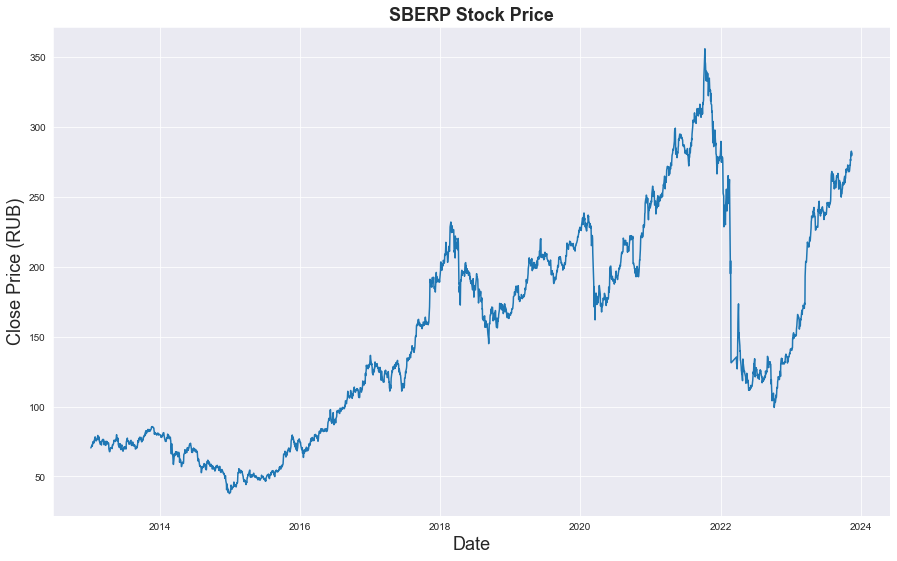

In [6]:
sns.set_style("darkgrid")
plt.figure(figsize = (15,9))
plt.plot(data[['CLOSE']])
plt.title(f"{sym} Stock Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (RUB)',fontsize=18)
plt.show()

In [7]:
# Adding indicators
data['RSI'] = ta.rsi(data.CLOSE, length=15)
data['EMAF'] = ta.ema(data.CLOSE, length=20)
data['EMAM'] = ta.ema(data.CLOSE, length=100)
data['EMAS'] = ta.ema(data.CLOSE, length=150)
data['VWAP'] = ta.vwap(data.HIGH, data.LOW, data.CLOSE, data.VOL, anchor = "D")
data

,TICKER,PER,TIME,OPEN,HIGH,LOW,CLOSE,VOL,RSI,EMAF,EMAM,EMAS,VWAP
DATE,,,,,,,,,,,,,
2013-01-08,SBERP,D,0,68.99,70.78,68.72,70.38,17944900,NaN,NaN,NaN,NaN,69.960000
2013-01-09,SBERP,D,0,70.36,71.30,70.12,70.69,15790900,NaN,NaN,NaN,NaN,70.703333
2013-01-10,SBERP,D,0,70.87,71.00,70.50,70.90,12258200,NaN,NaN,NaN,NaN,70.800000
2013-01-11,SBERP,D,0,70.91,71.67,70.72,71.32,15105700,NaN,NaN,NaN,NaN,71.236667
2013-01-14,SBERP,D,0,71.67,72.70,71.65,72.47,18319300,NaN,NaN,NaN,NaN,72.273333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-09,SBERP,D,0,277.11,277.47,274.81,276.05,2706820,66.926851,269.650106,255.133587,244.011538,276.110000
2023-11-10,SBERP,D,0,276.19,279.90,275.85,279.30,4346280,70.862265,270.569143,255.612130,244.478935,278.350000
2023-11-13,SBERP,D,0,279.61,283.98,279.50,282.74,3733460,74.326717,271.728273,256.149315,244.985704,282.073333


In [8]:
data['Target'] = data['CLOSE'] - data.OPEN
data['Target'] = data['Target'].shift(-1)
data['TargetClass'] = [1 if data.Target[i] > 0 else 0 for i in range(len(data))]
data['TargetNextClose'] = data['CLOSE'].shift(-1)
pd.set_option('display.max_columns', None)
data

,TICKER,PER,TIME,OPEN,HIGH,LOW,CLOSE,VOL,RSI,EMAF,EMAM,EMAS,VWAP,Target,TargetClass,TargetNextClose
DATE,,,,,,,,,,,,,,,,
2013-01-08,SBERP,D,0,68.99,70.78,68.72,70.38,17944900,NaN,NaN,NaN,NaN,69.960000,0.33,1,70.69
2013-01-09,SBERP,D,0,70.36,71.30,70.12,70.69,15790900,NaN,NaN,NaN,NaN,70.703333,0.03,1,70.90
2013-01-10,SBERP,D,0,70.87,71.00,70.50,70.90,12258200,NaN,NaN,NaN,NaN,70.800000,0.41,1,71.32
2013-01-11,SBERP,D,0,70.91,71.67,70.72,71.32,15105700,NaN,NaN,NaN,NaN,71.236667,0.80,1,72.47
2013-01-14,SBERP,D,0,71.67,72.70,71.65,72.47,18319300,NaN,NaN,NaN,NaN,72.273333,-0.80,0,71.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-09,SBERP,D,0,277.11,277.47,274.81,276.05,2706820,66.926851,269.650106,255.133587,244.011538,276.110000,3.11,1,279.30
2023-11-10,SBERP,D,0,276.19,279.90,275.85,279.30,4346280,70.862265,270.569143,255.612130,244.478935,278.350000,3.13,1,282.74
2023-11-13,SBERP,D,0,279.61,283.98,279.50,282.74,3733460,74.326717,271.728273,256.149315,244.985704,282.073333,-3.17,0,279.54


In [9]:
data.dropna(inplace=True)
data.reset_index(inplace=True)
data.drop(['VOL', 'CLOSE', 'TICKER', 'PER', 'TIME' ], axis=1, inplace=True)
data_set = data.iloc[:, 0:13]
pd.set_option('display.max_columns', None)
data_set

,DATE,OPEN,HIGH,LOW,RSI,EMAF,EMAM,EMAS,VWAP,Target,TargetClass,TargetNextClose
0,2013-08-09,72.50,73.20,72.02,48.571120,73.644141,73.296521,73.652800,72.780000,0.08,1,73.15
1,2013-08-12,73.07,73.50,72.22,48.697331,73.597080,73.293619,73.646140,72.956667,1.00,1,74.15
2,2013-08-13,73.15,74.37,72.93,52.831464,73.649739,73.310577,73.652814,73.816667,0.35,1,74.59
3,2013-08-14,74.24,74.90,74.01,54.557778,73.739288,73.335912,73.665227,74.500000,-1.96,0,72.51
4,2013-08-15,74.47,74.57,72.40,46.025916,73.622213,73.319558,73.649926,73.160000,-0.48,0,72.02
...,...,...,...,...,...,...,...,...,...,...,...,...
2566,2023-11-08,272.70,277.00,272.59,69.070077,268.976433,254.711033,243.581491,275.480000,-1.06,0,276.05
2567,2023-11-09,277.11,277.47,274.81,66.926851,269.650106,255.133587,244.011538,276.110000,3.11,1,279.30
2568,2023-11-10,276.19,279.90,275.85,70.862265,270.569143,255.612130,244.478935,278.350000,3.13,1,282.74
2569,2023-11-13,279.61,283.98,279.50,74.326717,271.728273,256.149315,244.985704,282.073333,-3.17,0,279.54


In [10]:
feature = data_set.iloc[:, 0:10]
target = data_set.iloc[:, -1:]

In [11]:
train_X, test_X, train_y, test_y = train_test_split(feature, target, shuffle=False, test_size=0.1, random_state = RANDOM_STATE)
val_X, test_X, val_y, test_y = train_test_split(test_X,test_y, shuffle=False, test_size=0.5, random_state = RANDOM_STATE)

print('train_X', train_X.shape, 'train_y', train_y.shape)
print('val_X',val_X.shape, 'val_y',val_y.shape)
print('test_X',test_X.shape, 'test_y',test_y.shape)

train_X (2313, 10) train_y (2313, 1)
val_X (129, 10) val_y (129, 1)
test_X (129, 10) test_y (129, 1)


In [12]:
sc = MinMaxScaler(feature_range=(-1, 1))
train_feature_scaled = sc.fit_transform(train_X.iloc[:, 1:10])
train_target_scaled = sc.fit_transform(train_y.iloc[:, -1:])
val_feature_scaled = sc.fit_transform(val_X.iloc[:, 1:10])
val_target_scaled = sc.fit_transform(val_y.iloc[:, -1:])
test_feature_scaled = sc.fit_transform(test_X.iloc[:, 1:10])
test_target_scaled = sc.fit_transform(test_y.iloc[:, -1:])

In [13]:
train_time = train_X['DATE']
val_time = val_X['DATE']
test_time = test_X['DATE']

In [14]:
train_series = train_target_scaled.flatten().tolist()
val_series = val_target_scaled.flatten().tolist()
test_series = test_target_scaled.flatten().tolist()

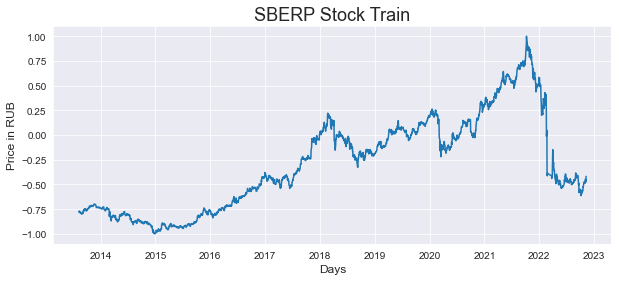

In [15]:
plt.figure(figsize=(10, 4))
plt.plot(train_time, train_series)
plt.xlabel('Days', fontsize=12)
plt.ylabel('Price in RUB', fontsize=12)
plt.title(f'{sym} Stock Train', fontsize=18)
plt.show()

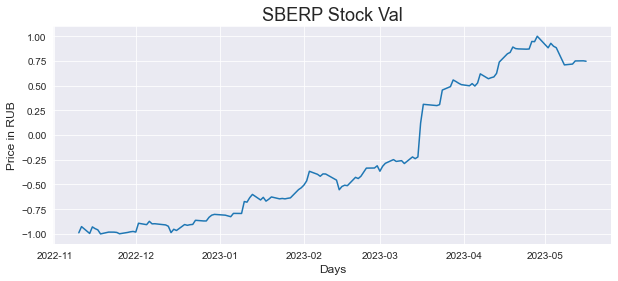

In [16]:
plt.figure(figsize=(10, 4))
plt.plot(val_time, val_series)
plt.xlabel('Days', fontsize=12)
plt.ylabel('Price in RUB', fontsize=12)
plt.title(f'{sym} Stock Val', fontsize=18)
plt.show()

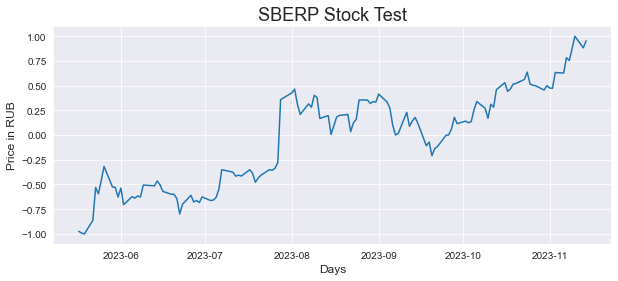

In [17]:
plt.figure(figsize=(10, 4))
plt.plot(test_time, test_series)
plt.xlabel('Days', fontsize=12)
plt.ylabel('Price in RUB', fontsize=12)
plt.title(f'{sym} Stock Test', fontsize=18)
plt.show()

In [18]:
class SeriesDataset(Dataset):
                            def __init__(self, feature, target, window_size):
                                    self.feature = feature
                                    self.target = target                
                                    self.window_size = window_size
                                    
                                    self.sequence = []
                                    for j in range(self.feature.shape[1]):
                                                    self.sequence.append([])
                                            
                                                    for i in range(self.feature.shape[0] - self.window_size):
                                                            self.sequence[j].append(self.feature[i : i + self.window_size, j])
                                  
                                    self.sequence = np.array(np.moveaxis(self.sequence, [0], [2]))

                                    self.y = np.array(self.target[self.window_size:])

                        
                            def __len__(self):
                                                return len(self.feature) - self.window_size

                            def __getitem__(self, idx):
                                                sequence = self.sequence[idx]
                                                label = self.y[idx]
                                                
                                                 
                                                sequence = torch.tensor(sequence).float()
                                                label = torch.tensor(label).float()
                     
#                                            
                                                return sequence, label

In [19]:
train_dataset = SeriesDataset(train_feature_scaled, train_target_scaled, WINDOW_SIZE)
train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True)
train_dataloader1 = DataLoader(train_dataset, batch_size = BATCH_SIZE)

In [20]:
val_dataset = SeriesDataset(val_feature_scaled, val_target_scaled, WINDOW_SIZE)
val_dataloader = DataLoader(val_dataset, batch_size = BATCH_SIZE)

In [21]:
test_dataset = SeriesDataset(test_feature_scaled, test_target_scaled, WINDOW_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE)

In [22]:
train_dataset. __len__()

2283

In [23]:
train_dataset.__getitem__(1)[0].size()

torch.Size([30, 9])

In [24]:
train_dataset.__getitem__(1)[1].size()

torch.Size([1])

In [25]:
train_dataset.__getitem__(2282)

(tensor([[-0.5658, -0.5557, -0.5647, -0.4904, -0.4552, -0.3485, -0.1992, -0.5584,
           0.4918],
         [-0.5545, -0.5476, -0.5605, -0.5304, -0.4651, -0.3528, -0.2038, -0.5583,
           0.4746],
         [-0.5596, -0.5657, -0.5764, -0.5593, -0.4750, -0.3571, -0.2086, -0.5725,
           0.5199],
         [-0.5665, -0.5633, -0.5905, -0.5389, -0.4836, -0.3613, -0.2132, -0.5754,
           0.6322],
         [-0.5658, -0.5528, -0.5570, -0.3613, -0.4889, -0.3649, -0.2174, -0.5527,
           0.4313],
         [-0.5387, -0.5498, -0.5479, -0.4248, -0.4953, -0.3687, -0.2218, -0.5539,
           0.4604],
         [-0.5589, -0.5708, -0.5701, -0.4801, -0.5025, -0.3728, -0.2263, -0.5730,
           0.5410],
         [-0.5731, -0.5746, -0.5618, -0.4576, -0.5087, -0.3767, -0.2308, -0.5705,
           0.3543],
         [-0.5711, -0.5826, -0.6002, -0.5971, -0.5183, -0.3815, -0.2358, -0.5985,
           0.7371],
         [-0.6281, -0.5935, -0.6260, -0.4197, -0.5244, -0.3856, -0.2403, -0.6024,


In [26]:
class My_Model_GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_p = 0.1):
        super(My_Model_GRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.relu = nn.ReLU()
        self.do = nn.Dropout(dropout_p)
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                                                        num_layers=num_layers, batch_first=True, bidirectional=True)
        self.linear1 = nn.Linear(hidden_size * 2, hidden_size )
        self.linear2 = nn.Linear(hidden_size , output_size)
        
    def forward(self, x):
            
        output, _ = self.gru(x)
        output = self.linear1(self.do(output))
        output = self.relu(output)
        output = self.linear2(output)

        
        return output[:, -1, :]

In [27]:
model_my = My_Model_GRU(input_size, HIDDEN_SIZE, NUM_L, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_my.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [28]:
X,y = next(iter(train_dataloader))
output = model_my(X)
print(X.size())
print(y.size())
print(output.size())
# print(output.unsqueeze(0).size())
# loss = criterion(output, y)

torch.Size([128, 30, 9])
torch.Size([128, 1])
torch.Size([128, 1])


In [29]:
class Optimization:
    """ A helper class to train, test and diagnose the GRU"""

    def __init__(self, model, loss_fn, optimizer, scheduler):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_losses = []
        self.val_losses = []

    def train(
        self,
        dataloader_train,
        n_epochs,
        dataloader_val = None,
    
    ):
        for epoch in range(n_epochs):
            start_time = time.time()
            train_loss = 0
            loop = tqdm(dataloader_train, desc='Train', colour='green')
            for b, batch in enumerate(loop):
                x_batch, y_batch = batch[0], batch[1]
                y_pred = self.model(x_batch)
                self.optimizer.zero_grad()
                loss = self.loss_fn(y_pred, y_batch)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
            self.scheduler.step()
            train_loss /= (b+1)
            self.train_losses.append(train_loss)

            self._validation(dataloader_val)

            elapsed = time.time() - start_time
            print(
                "Epoch %d Train loss: %.2f. Validation loss: %.2f. Elapsed time: %.2fs."
                % (epoch + 1, train_loss, self.val_losses[-1], elapsed)
            )
            
            torch.save(self.model.state_dict(), f'./chkpt_mymodel_{epoch+1}.pth')
    
    def _validation(self, dataloader_val):
        if dataloader_val is None:
            return
        with torch.no_grad():
            val_loss = 0
            loop = tqdm(dataloader_val, desc='Val', colour='green')
            for b, batch in enumerate(loop):
                x_batch, y_batch = batch[0], batch[1]
                y_pred = self.model(x_batch)
                loss = self.loss_fn(y_pred, y_batch)
                val_loss += loss.item()
            val_loss /= b+1
            self.val_losses.append(val_loss)

    def evaluate(self, dataloader_test):
        with torch.no_grad():
            test_loss = 0
            actual, predicted = [], []
            loop = tqdm(dataloader_test, desc='Test', colour='green')
            for b, batch in enumerate(loop):
                x_batch, y_batch = batch[0], batch[1]
                y_pred = self.model(x_batch)
                loss = self.loss_fn(y_pred, y_batch)
                            
                actual += torch.squeeze(y_batch[:, -1]).data.cpu().numpy().tolist()
                predicted += torch.squeeze(y_pred[:, -1]).data.cpu().numpy().tolist()

                
#                 actual.append(torch.squeeze(y_batch[:, -1]).data.cpu().numpy().tolist())
#                 predicted.append(torch.squeeze(y_pred[:, -1]).data.cpu().numpy().tolist())
                
                
            
            test_loss /= (b+1)
            return actual, predicted, test_loss

    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")

In [30]:
optimization_1 = Optimization(model_my, criterion, optimizer, scheduler)

In [31]:
optimization_1.train(train_dataloader, n_epochs = EPOCHS, dataloader_val = val_dataloader)

Val: 100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


Epoch 1 Train loss: 1.17. Validation loss: 0.26. Elapsed time: 39.19s.


Val: 100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]


Epoch 2 Train loss: 0.03. Validation loss: 0.07. Elapsed time: 37.20s.


Val: 100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.57it/s]


Epoch 3 Train loss: 0.01. Validation loss: 0.04. Elapsed time: 36.04s.


Val: 100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.57it/s]


Epoch 4 Train loss: 0.00. Validation loss: 0.03. Elapsed time: 36.11s.


Val: 100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.53it/s]


Epoch 5 Train loss: 0.00. Validation loss: 0.02. Elapsed time: 36.22s.


Val: 100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.62it/s]


Epoch 6 Train loss: 0.00. Validation loss: 0.03. Elapsed time: 36.05s.


Val: 100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.56it/s]


Epoch 7 Train loss: 0.00. Validation loss: 0.03. Elapsed time: 36.27s.


Val: 100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.63it/s]


Epoch 8 Train loss: 0.00. Validation loss: 0.03. Elapsed time: 36.40s.


Val: 100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


Epoch 9 Train loss: 0.00. Validation loss: 0.03. Elapsed time: 37.54s.


Val: 100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.58it/s]

Epoch 10 Train loss: 0.00. Validation loss: 0.03. Elapsed time: 36.35s.


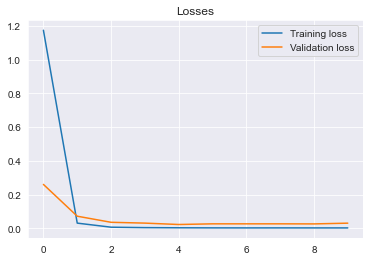

In [32]:
optimization_1.plot_losses()

In [33]:
def to_dataframe(actual, predicted):
    return pd.DataFrame({"actual": actual, "predicted": predicted})


def inverse_transform(scalar, df, columns):
    for col in columns:
        df[col] = scalar.inverse_transform(np.array(df[col]).reshape(-1,1))
    return df

Test: 100%|████████████████████████████████████████████████████████████████████████████| 18/18 [00:14<00:00,  1.27it/s]


Train loss 0.0000


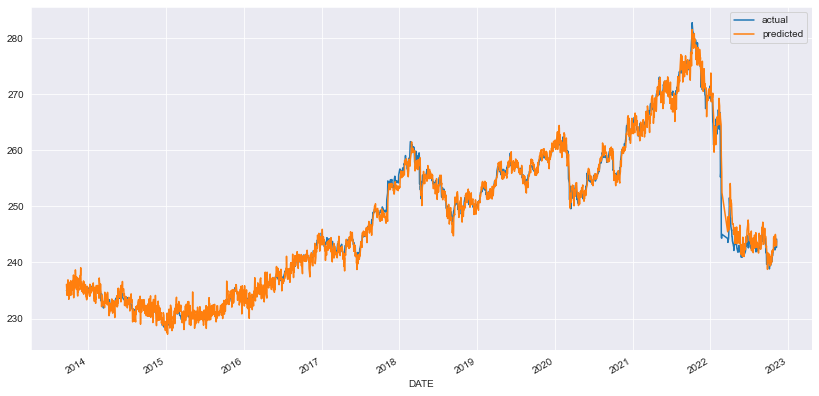

In [34]:
actual_3, predicted_3, train_loss_3 = optimization_1.evaluate(train_dataloader1)
df_result_3 = to_dataframe(actual_3, predicted_3) 
# df_result_3

df_result_3 = inverse_transform(sc, df_result_3, ['actual', 'predicted'])

df_result_3 = df_result_3.set_index(train_time[WINDOW_SIZE:])

df_result_3.plot(figsize=(14, 7))
print("Train loss %.4f" % train_loss_3)

In [35]:
optimization_1.model

My_Model_GRU(
  (relu): ReLU()
  (do): Dropout(p=0.1, inplace=False)
  (gru): GRU(9, 256, num_layers=2, batch_first=True, bidirectional=True)
  (linear1): Linear(in_features=512, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=1, bias=True)
)

Test: 100%|██████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.58it/s]


Val loss 0.0000


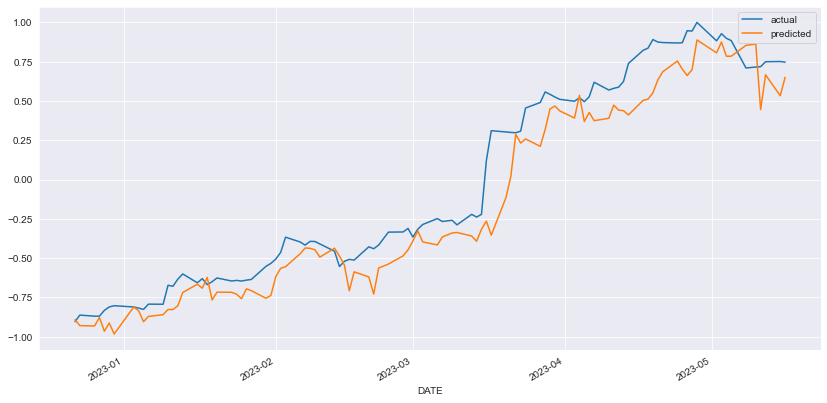

In [36]:
actual_2, predicted_2, val_loss_2 = optimization_1.evaluate(val_dataloader)
df_result_2 = to_dataframe(actual_2, predicted_2) 
# df_result_1

# df_result_2 = inverse_transform(sc, df_result_2, ['actual', 'predicted'])

df_result_2 = df_result_2.set_index(val_time[WINDOW_SIZE:])
df_result_2.plot(figsize=(14, 7))
print("Val loss %.4f" % val_loss_2)

Test: 100%|██████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.54it/s]


Test loss 0.0000


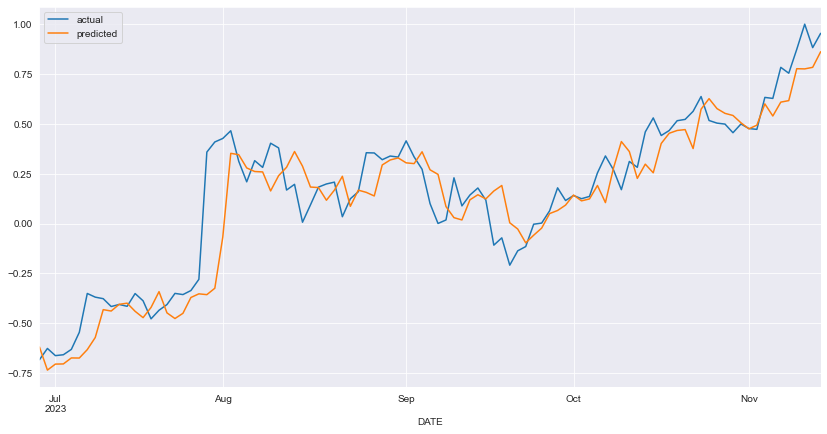

In [37]:
actual_1, predicted_1, test_loss_1 = optimization_1.evaluate(test_dataloader)
df_result_11 = to_dataframe(actual_1, predicted_1) 
# df_result_1

# df_result_11 = inverse_transform(sc, df_result_11, ['actual', 'predicted'])

df_result_1 = df_result_11.set_index(test_time[WINDOW_SIZE:])
df_result_1.plot(figsize=(14, 7))
print("Test loss %.4f" % test_loss_1)

In [38]:
optimization_1.model.eval()

My_Model_GRU(
  (relu): ReLU()
  (do): Dropout(p=0.1, inplace=False)
  (gru): GRU(9, 256, num_layers=2, batch_first=True, bidirectional=True)
  (linear1): Linear(in_features=512, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=1, bias=True)
)

In [39]:
price = test_X.iloc[-WINDOW_SIZE:]
price = price.iloc[:, 1:10]
price = sc.fit_transform(price)
price.shape

(30, 9)

In [40]:
price = torch.tensor(price).float()
price.shape

torch.Size([30, 9])

In [41]:
price = price.unsqueeze(0)
price.shape

torch.Size([1, 30, 9])

In [48]:
with torch.no_grad():
    prediction = optimization_1.model(price).item()

arr = np.zeros(8)
f = np.concatenate((arr, np.array([prediction])), axis=0)
t = f.reshape(1, -1)
predictions = sc.inverse_transform(t)
predictions

array([[270.805     , 272.075     , 268.65      ,  63.29471382,
        265.03291755, 251.22835275, 239.6381168 , 270.595     ,
          3.76133051]])